In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
from keras import regularizers ### for SVM
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
from keras.models import load_model

tf.reset_default_graph()


from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from models.cnn import mini_XCEPTION
from utils.datasets import DataManager
from utils.preprocessor import preprocess_input
# OpenCV
import cv2

Using TensorFlow backend.


In [2]:
## import dataset

trainingset_x = np.load('Dataset/Wiki_train_x_onehot.npy')
trainingset_y = np.load('Dataset/Wiki_train_y_onehot.npy')

valset_x = np.load('Dataset/Wiki_val_x_onehot.npy')
valset_y = np.load('Dataset/Wiki_val_y_onehot.npy')

In [3]:
#### data processing
img_dim = 64
n_channels = 1
n_inputs = img_dim*img_dim


trainingset_x = trainingset_x.reshape(trainingset_x.shape[0], img_dim, img_dim)
trainingset_x = np.expand_dims(trainingset_x, axis=4)

valset_x = valset_x.reshape(valset_x.shape[0], img_dim, img_dim)
valset_x = np.expand_dims(valset_x, axis=4)

In [4]:
print(trainingset_x.shape[0],trainingset_x.shape[1], trainingset_x.shape[2],trainingset_x.shape[3] )
print(valset_x.shape[0], valset_x.shape[1], valset_x.shape[2], valset_x.shape[3] )

11938 64 64 1
5968 64 64 1


In [5]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [6]:
def get_label(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'female'
    elif indx == 1:
        return 'male'

In [7]:
def predict_gender_from_image_file(model, file_name):
    img = cv2.imread(file_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.imshow(img, cmap='gray')
    plt.axis('off')

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (64, 64))

    img = cv2.transpose(img)
    img = img.reshape([1, img_dim, img_dim, 1])
    proba = model.predict(img, verbose=0)
    pred_cls = np.argmax(proba,axis=1)    
    proba = model.predict(img, verbose=0)

#     print('> predicted gender: %s (%f%%)'
#           % (get_label(pred_cls), np.max(proba)))
    
    if np.max(proba) >= 0.700:
        plt.title('predicted gender: ' + get_label(pred_cls) + ' (' + str(np.max(proba)) + '%)')
    else:
        plt.title('predicted gender: unknown (' + str(np.max(proba)) + '% is ' + get_label(pred_cls) + ')')
    plt.show()

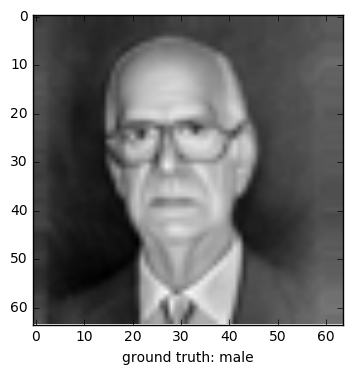

In [8]:
##### plot  same  example 
indx = 100
img = trainingset_x[indx, :]
img = img.reshape([img_dim, img_dim])
img = np.transpose(img)
plt.imshow(img, cmap='gray')
plt.xlabel('ground truth: ' + get_label(trainingset_y[indx]))
plt.show()

In [9]:
input_shape = (64, 64, 1)
num_classes = 2

In [10]:
model = mini_XCEPTION(input_shape, num_classes)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 62, 62, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 62, 62, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
opt = Adam(lr=0.001, decay=10e-6)

model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

In [13]:
batch_size = 128
n_epoches = 300

from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "weights.gender_wiki.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
history = model.fit_generator(data_generator.flow(trainingset_x, trainingset_y, batch_size), steps_per_epoch=int(len(trainingset_x) / batch_size), validation_data = (valset_x, valset_y), epochs=n_epoches, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/300
 - 25s - loss: 0.5906 - acc: 0.7913 - val_loss: 0.7892 - val_acc: 0.6089

Epoch 00001: val_acc improved from -inf to 0.60891, saving model to weights.gender_wiki.best.hdf5
Epoch 2/300
 - 20s - loss: 0.5515 - acc: 0.8023 - val_loss: 0.6384 - val_acc: 0.7981

Epoch 00002: val_acc improved from 0.60891 to 0.79809, saving model to weights.gender_wiki.best.hdf5
Epoch 3/300
 - 20s - loss: 0.5250 - acc: 0.8105 - val_loss: 0.6221 - val_acc: 0.7949

Epoch 00003: val_acc did not improve
Epoch 4/300
 - 20s - loss: 0.4917 - acc: 0.8195 - val_loss: 0.5099 - val_acc: 0.8152

Epoch 00004: val_acc improved from 0.79809 to 0.81518, saving model to weights.gender_wiki.best.hdf5
Epoch 5/300
 - 20s - loss: 0.4797 - acc: 0.8238 - val_loss: 0.4991 - val_acc: 0.8135

Epoch 00005: val_acc did not improve
Epoch 6/300
 - 20s - loss: 0.4729 - acc: 0.8255 - val_loss: 0.4715 - val_acc: 0.8269

Epoch 00006: val_acc improved from 0.81518 to 0.82691, saving model to weights.gender_wiki.best.hdf5
Epoch 7/3

In [14]:
scores = model.evaluate(valset_x, valset_y)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

5968/5968 [==============================] - 1s 249us/step
acc: 86.19%


In [15]:
model.load_weights('weights.gender_wiki.best.hdf5')

In [16]:
scores = model.evaluate(valset_x, valset_y)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

5968/5968 [==============================] - 1s 243us/step
acc: 88.39%


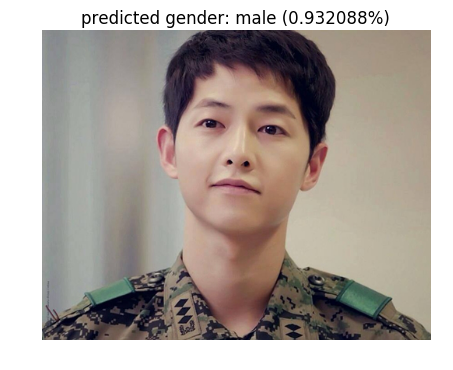

In [17]:
file_name = 'Dataset/Test_images/Song_Joong_Ki_2.jpg'
predict_gender_from_image_file(model, file_name)